# 本文件说明
- 统计分析
> - 八分类模型数据：噪音与非噪音
> - 补录和预警数据

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import time

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_cor\%s_%s.jpg"%(now, title))

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()
    
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.savefig("figure\plot_tend\%s_%s.jpg"%(now, title))
    
    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['监管', '行业', '公司内部管理', '消费服务']
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_cor', 'sum']
    count_data_4['al_uncor'] = count_data_4['sum'] - count_data_4['al_cor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

# 参数设置

In [9]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-12-04
昨天是： 2018-12-03
统计的是昨天的数据，即 2018-12-03 的数据
start_day： 2018-11-03
end_day： 2018-12-04


In [10]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,
           '消费服务':6,'其他相关报道':7,'噪音':8,'交通':9,'环保':10}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音',
 9: '交通',
 10: '环保'}

In [11]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

In [12]:
proj_dic={'银监会':1,'保监会':2,'中国人寿':3,'建行北分':4,'中国人保':5}
proj_name_dict = {v: k for k, v in proj_dic.items()}
proj_name_dict

{1: '银监会', 2: '保监会', 3: '中国人寿', 4: '建行北分', 5: '中国人保'}

# 保险业--旧

## 特殊时间点

In [13]:
engine = specific_func.get_engine('circ')

In [14]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [15]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-12-03,补录,4
1,2018-12-03,监管,3252
2,2018-12-03,行业,1336
3,2018-12-03,产品销售,788
4,2018-12-03,资本市场,2767


In [16]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-12-03,噪音,45975
1,2018-12-02,噪音,63127
2,2018-12-01,噪音,92916
3,2018-11-30,噪音,109332
4,2018-11-29,噪音,129477


### 补录数据

,publishtime,补录
0,2018-12-03,4
22,2018-11-30,5
30,2018-11-29,5
38,2018-11-28,6
46,2018-11-27,14


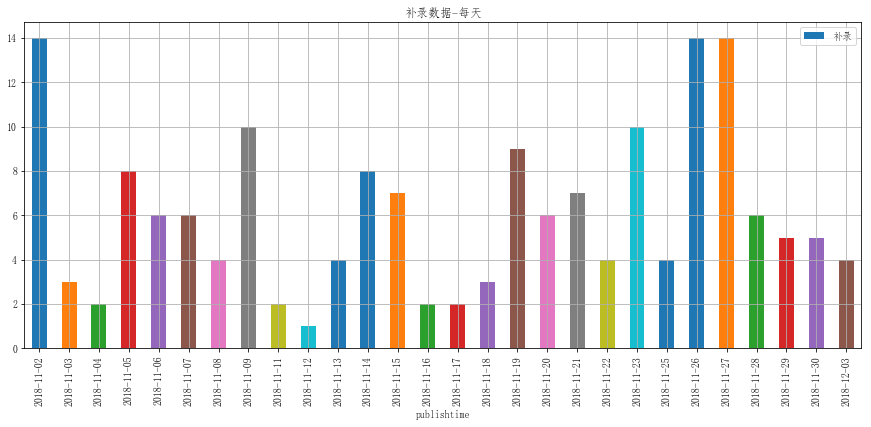

In [17]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [18]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                          \
classify        产品销售   公司内部管理   其他相关报道         噪音     消费服务       监管       行业   
publishtime                                                                    
2018-12-03   788.000  970.000 1055.000  45975.000  804.000 3252.000 1336.000   
2018-12-02  1803.000  701.000  687.000  63127.000 1138.000 3509.000  973.000   
2018-12-01  2178.000 2067.000 1993.000  92916.000 1674.000 4496.000 2713.000   
2018-11-30  1947.000 1910.000 2369.000 109332.000 2254.000 4856.000 1895.000   
2018-11-29  3041.000 2661.000 2584.000 129477.000 3200.000 5003.000 3136.000   

                                   总量       非噪音 非噪音-比例 噪音-比例  
classify       补录     资本市场                                    
publishtime                                                   
2018-12-03  4.000 2767.000  56951.000 10976.000  0.193 0.807  
2018-12-02    nan 2193.000  74131.000 11004.000  0.148 0.852  
2018-12-01    nan 3409.000 111446.000 18530.000  0.166 0.834  
2018-11-30  5.000 4669.000 129237.000 19905.000  0.154 0.846  
2018-11-29  5.000 5860.000 154967.000 25490.000  0.164 0.836

count                                                          \
classify        产品销售   公司内部管理   其他相关报道         噪音     消费服务       监管       行业   
publishtime                                                                    
2018-12-03   788.000  970.000 1055.000  45975.000  804.000 3252.000 1336.000   
2018-12-02  1803.000  701.000  687.000  63127.000 1138.000 3509.000  973.000   
2018-12-01  2178.000 2067.000 1993.000  92916.000 1674.000 4496.000 2713.000   
2018-11-30  1947.000 1910.000 2369.000 109332.000 2254.000 4856.000 1895.000   
2018-11-29  3041.000 2661.000 2584.000 129477.000 3200.000 5003.000 3136.000   

                                   总量  rate                                  \
classify       补录     资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                   
2018-12-03  4.000 2767.000  56951.000 0.014  0.017  0.019 0.807 0.014 0.057   
2018-12-02    nan 2193.000  74131.000 0.024  0.009  0.009 0.852 0.015 0.047   
2018-12-01    nan 3409.000 111446.000 0.020  0.019  0.018 0.834 0.015 0.040   
2018-11-30  5.000 4669.000 129237.000 0.015  0.015  0.018 0.846 0.017 0.038   
2018-11-29  5.000 5860.000 154967.000 0.020  0.017  0.017 0.836 0.021 0.032   

                               
classify       行业    补录  资本市场  
publishtime                    
2018-12-03  0.023 0.000 0.049  
2018-12-02  0.013   nan 0.030  
2018-12-01  0.024   nan 0.031  
2018-11-30  0.015 0.000 0.036  
2018-11-29  0.020 0.000 0.038

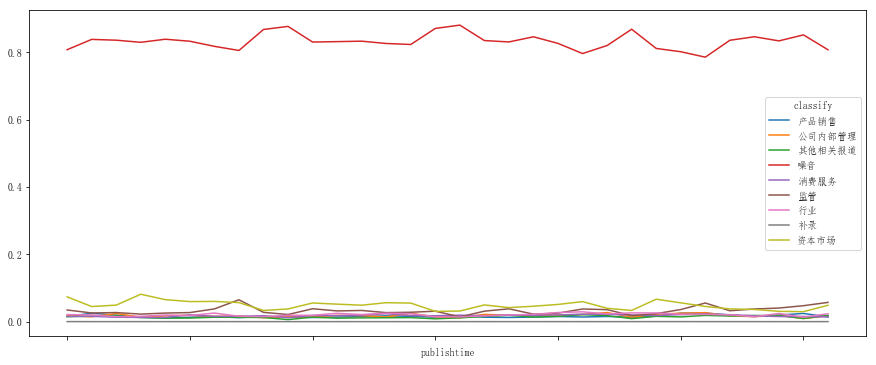

In [19]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

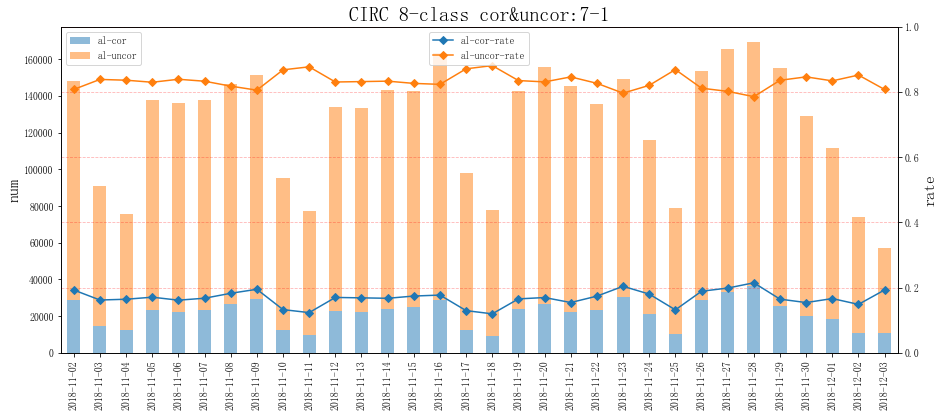

   publishtime        sum    al_cor   al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-03  56951.000 10976.000  45975.000        0.193          0.807
30  2018-12-02  74131.000 11004.000  63127.000        0.148          0.852
29  2018-12-01 111446.000 18530.000  92916.000        0.166          0.834
28  2018-11-30 129237.000 19905.000 109332.000        0.154          0.846
27  2018-11-29 154967.000 25490.000 129477.000        0.164          0.836


In [20]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

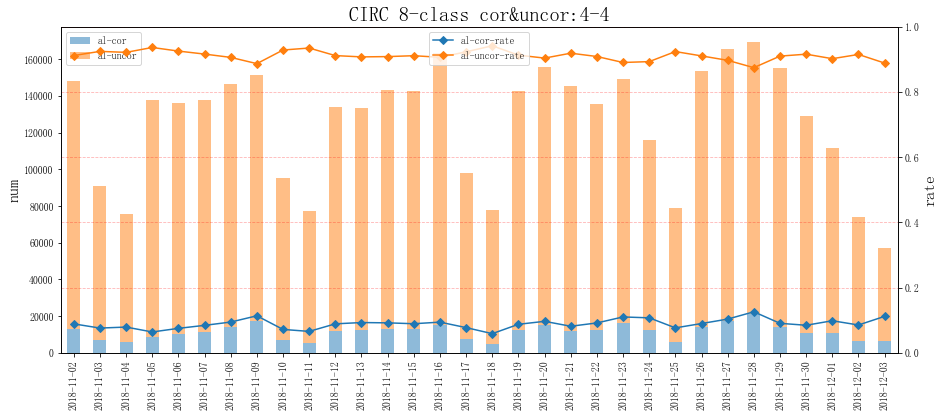

   publishtime    al_cor        sum   al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-03  6362.000  56951.000  50589.000        0.112          0.888
30  2018-12-02  6321.000  74131.000  67810.000        0.085          0.915
29  2018-12-01 10950.000 111446.000 100496.000        0.098          0.902
28  2018-11-30 10915.000 129237.000 118322.000        0.084          0.916
27  2018-11-29 14000.000 154967.000 140967.000        0.090          0.910


In [21]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [22]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-12-03,-1,3017
1,2018-12-03,0,8163
2,2018-12-02,-1,2609
3,2018-12-02,0,8404
4,2018-12-01,-1,3998


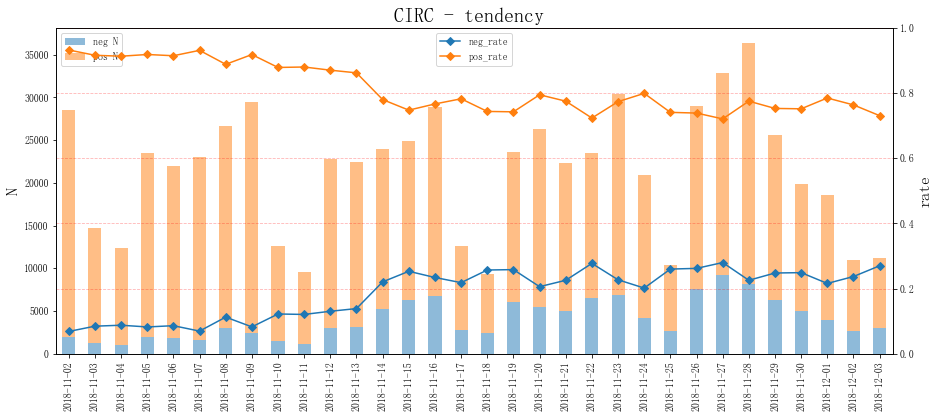

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-12-03  3017   8163  11180     0.270     0.730
30  2018-12-02  2609   8404  11013     0.237     0.763
29  2018-12-01  3998  14536  18534     0.216     0.784
28  2018-11-30  4954  14954  19908     0.249     0.751
27  2018-11-29  6335  19239  25574     0.248     0.752


In [23]:
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [24]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [25]:
add_start_day = '2018-10-27'
add_end_day = '2018-11-02'

In [26]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(68, 7)


In [27]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(124, 7)


In [28]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (192, 7)
去重后 (126, 7)


In [29]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,11677278,监管,,1,1
1,11684462,噪音,,0,0
2,11686197,产品销售,,0,1
3,11686236,噪音,,0,0
4,11686238,消费服务,,1,1


In [30]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [31]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [32]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,新闻,新闻客户端,纸媒,视频,总量
保监会：2018-10-27 到 2018-11-02,,,,,,
补录,12.000,42.000,3.000,9.000,2.000,68.000
预警数量,12.000,73.000,2.000,35.000,2.000,124.000
补录且预警,12.000,41.000,2.000,9.000,2.000,66.000
补录&过算法(7类),11.000,37.000,3.000,8.000,1.000,60.000
补录且预警&过算法(7类),11.000,36.000,2.000,8.000,1.000,58.000
补录且预警 / 预警-比例,100%,56%,100%,26%,100%,53%
补录且预警 / 补录-比例,100%,98%,67%,100%,100%,97%
补录&过算法(7类) / 补录-比例,92%,88%,100%,89%,50%,88%
补录且预警&过算法(7类) / 补录且预警-比例,92%,88%,100%,89%,50%,88%


### 导出一段时间补录数据用于训练

In [33]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [34]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [35]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧

## 特殊时间点

In [36]:
engine = specific_func.get_engine('cbrc')

In [37]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [38]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-12-03,监管,5549
1,2018-12-03,行业,7575
2,2018-12-03,产品销售,1667
3,2018-12-03,资本市场,10411
4,2018-12-03,公司内部管理,1995


### class

In [39]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                       总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务    监管     行业   资本市场           
publishtime                                                                  
2018-12-03   1667   1995   2135   53993   5894  5549   7575  10411   89219   
2018-12-02   2157   1171   2012   73829  11398  4783   6699   8745  110794   
2018-12-01   2854   2658   4567  100148  17427  7781   9173  16010  160618   
2018-11-30   3790   3392   5135  118762  32445  8460  14131  20433  206548   
2018-11-29   3902   3953   5907  130227  27170  9813  16708  24100  221780   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-12-03   35226  0.395 0.605  
2018-12-02   36965  0.334 0.666  
2018-12-01   60470  0.376 0.624  
2018-11-30   87786  0.425 0.575  
2018-11-29   91553  0.413 0.587

count                                                       总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务    监管     行业   资本市场           
publishtime                                                                  
2018-12-03   1667   1995   2135   53993   5894  5549   7575  10411   89219   
2018-12-02   2157   1171   2012   73829  11398  4783   6699   8745  110794   
2018-12-01   2854   2658   4567  100148  17427  7781   9173  16010  160618   
2018-11-30   3790   3392   5135  118762  32445  8460  14131  20433  206548   
2018-11-29   3902   3953   5907  130227  27170  9813  16708  24100  221780   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-12-03  0.019  0.022  0.024 0.605 0.066 0.062 0.085 0.117  
2018-12-02  0.019  0.011  0.018 0.666 0.103 0.043 0.060 0.079  
2018-12-01  0.018  0.017  0.028 0.624 0.108 0.048 0.057 0.100  
2018-11-30  0.018  0.016  0.025 0.575 0.157 0.041 0.068 0.099  
2018-11-29  0.018  0.018  0.027 0.587 0.123 0.044 0.075 0.109

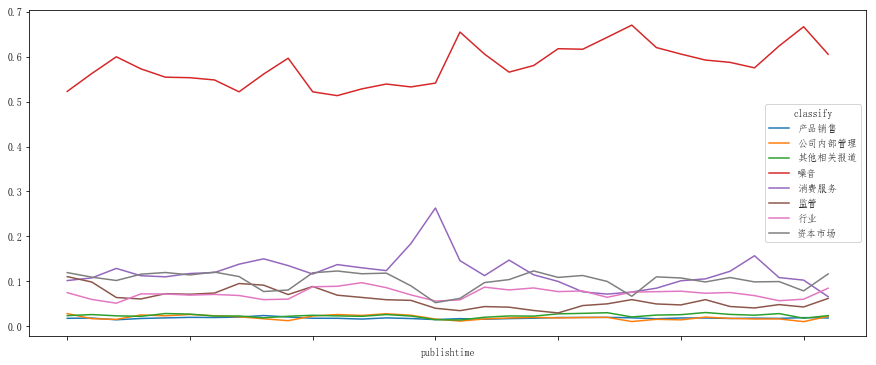

In [40]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

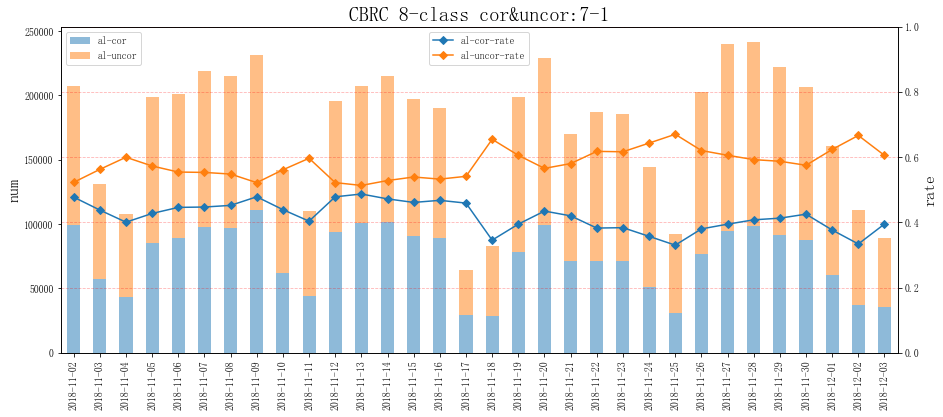

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-03   89219   35226     53993        0.395          0.605
30  2018-12-02  110794   36965     73829        0.334          0.666
29  2018-12-01  160618   60470    100148        0.376          0.624
28  2018-11-30  206548   87786    118762        0.425          0.575
27  2018-11-29  221780   91553    130227        0.413          0.587


In [41]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

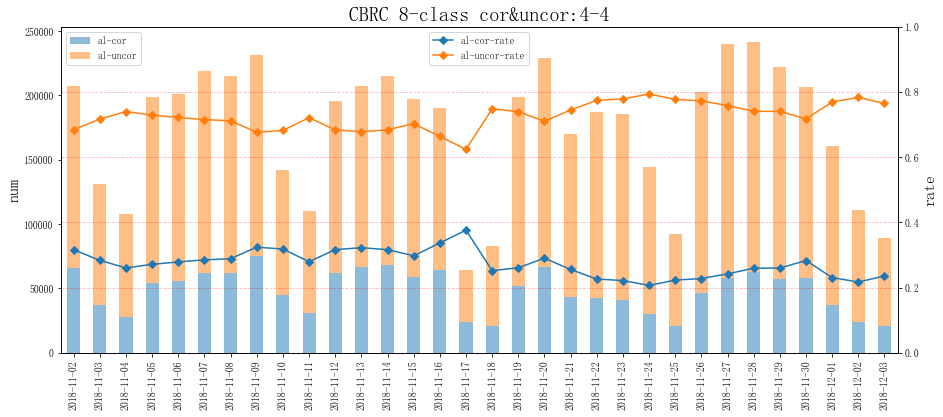

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-12-03   21013   89219     68206        0.236          0.764
30  2018-12-02   24051  110794     86743        0.217          0.783
29  2018-12-01   37039  160618    123579        0.231          0.769
28  2018-11-30   58428  206548    148120        0.283          0.717
27  2018-11-29   57644  221780    164136        0.260          0.740


In [42]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [43]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-12-03,-1,7636
1,2018-12-03,0,13755
3,2018-12-02,-1,12630
4,2018-12-02,0,11439
5,2018-12-01,-1,18451


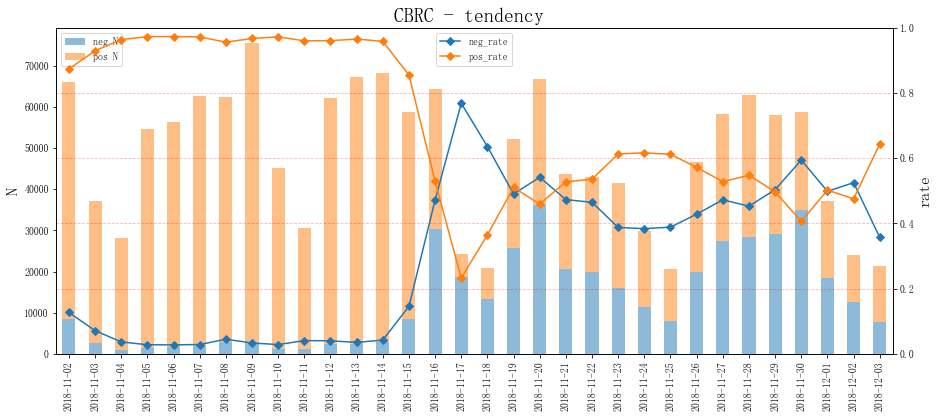

   publishtime    neg    pos    sum  neg_rate  pos_rate
31  2018-12-03   7636  13755  21391     0.357     0.643
30  2018-12-02  12630  11439  24069     0.525     0.475
29  2018-12-01  18451  18593  37044     0.498     0.502
28  2018-11-30  34860  23814  58674     0.594     0.406
27  2018-11-29  29166  28783  57949     0.503     0.497


In [44]:
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [45]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-12-03,1,25
1,2018-12-02,1,7
2,2018-12-01,1,10
3,2018-11-30,1,109
4,2018-11-29,1,92


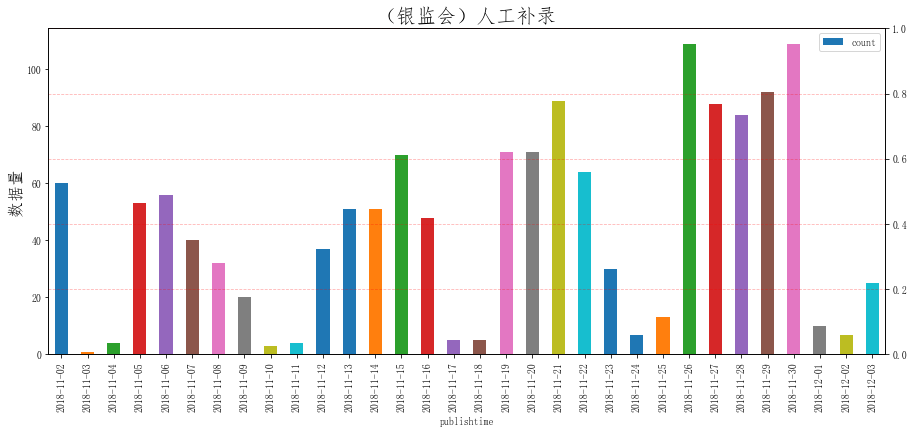

,publishtime,gather_type,count
0,2018-12-03,1,25
1,2018-12-02,1,7
2,2018-12-01,1,10
3,2018-11-30,1,109
4,2018-11-29,1,92


In [46]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [47]:
add_start_day = '2018-10-27'
add_end_day = '2018-11-02'

In [48]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(352, 7)


In [49]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(597, 7)


In [50]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (949, 7)
去重后 (598, 7)


In [51]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

gather_type  group_id  submited
4            微博        预警           42
人工修改         外媒        预警            1
             微信        预警            1
             微博        预警           68
             新闻        预警           50
             新闻客户端     预警            2
             纸媒        预警           73
             论坛        预警            9
人工补录         微信        预警            3
             微博        预警          319
             新闻        不预警           1
                       预警           18
             纸媒        预警            6
             论坛        预警            5
Name: id, dtype: int64

In [52]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,266631913,行业,,1,1
1,266632075,噪音,,0,0
2,266676256,噪音,,0,0
3,266683362,消费服务,,1,1
4,266683767,消费服务,,1,1


In [53]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [54]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [55]:
stat

,group_id,gather_type,submited,id
0,外媒,人工修改,预警,1
1,微信,人工修改,预警,1
2,微信,人工补录,预警,3
3,微博,4,预警,42
4,微博,人工修改,预警,68
5,微博,人工补录,预警,319
6,新闻,人工修改,预警,50
7,新闻,人工补录,不预警,1
8,新闻,人工补录,预警,18
9,新闻客户端,人工修改,预警,2


In [56]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
# stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
# stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

来源,微信,微博,新闻,纸媒,论坛,总量
保监会：2018-10-27 到 2018-11-02,,,,,,
补录,3.000,319.000,19.000,6.000,5.000,352.000
预警数量,4.000,429.000,68.000,79.000,14.000,594.000
补录且预警,3.000,319.000,18.000,6.000,5.000,351.000
补录&过算法(4类),3.000,298.000,10.000,5.000,4.000,320.000
补录且预警&过算法(4类),3.000,298.000,9.000,5.000,4.000,319.000
补录&过算法(7类),3.000,307.000,15.000,6.000,5.000,336.000
补录且预警&过算法(7类),3.000,307.000,14.000,6.000,5.000,335.000
补录且预警 / 预警-比例,75%,74%,26%,8%,36%,59%


### 导出一段时间补录数据用于训练

In [57]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [58]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [59]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 银保监会--新

## 特殊时间点

In [13]:
engine = specific_func.get_engine('cbirc')

In [14]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [ ]:
start_day = today - datetime.timedelta(days=8) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

start_day： 2018-11-26
end_day： 2018-12-03


## 获取数据

In [ ]:
cbirc_count_all = pd.DataFrame()
for t in range(3, len(proj_name_dict) + 1):
    t0 = time.time()
    print('获取 %s 的数据 -------'%(proj_name_dict[t]))
    sql_cbirc = '''
    SELECT 
        DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
        t2.type,
        t1.traffic_id AS classify,
        t2.sen as tendency, 
        COUNT(t1.id) AS count
    FROM
        cbrc_circ.db_classify_traffic_docinfo t1
            LEFT JOIN
        cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
            LEFT JOIN
        cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
    WHERE
        date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
            AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
            and t2.type = {2}
            and t1.type = t2.type
    GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id, t2.sen
    '''.format(start_day, end_day, t)

    cbirc_count_type = pd.read_sql(sql_cbirc, engine)
    cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
    print('    耗时：%s s'%(time.time() - t0))

获取 中国人寿 的数据 -------
    耗时：194.40511965751648 s
获取 建行北分 的数据 -------
    耗时：277.348863363266 s
获取 中国人保 的数据 -------


In [ ]:
# cbirc_count_all = pd.DataFrame()
t = 2
t0 = time.time()
print('获取 %s 的数据 -------'%(proj_name_dict[t]))
sql_cbirc = '''
SELECT 
    DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
    t2.type,
    t1.traffic_id AS classify,
    t2.sen as tendency, 
    COUNT(t1.id) AS count
FROM
    cbrc_circ.db_classify_traffic_docinfo t1
        LEFT JOIN
    cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
        LEFT JOIN
    cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
WHERE
    date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
        AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
        and t2.type = {2}
        and t1.type = t2.type        
GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id, t2.sen
'''.format(start_day, end_day, t)

cbirc_count_type = pd.read_sql(sql_cbirc, engine)
cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
print('    耗时：%s s'%(time.time() - t0))

In [ ]:
# cbirc_count_all = pd.DataFrame()
t = 1
t0 = time.time()
print('获取 %s 的数据 -------'%(proj_name_dict[t]))
sql_cbirc = '''
SELECT 
    DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
    t2.type,
    t1.traffic_id AS classify,
    t2.sen as tendency, 
    COUNT(t1.id) AS count
FROM
    cbrc_circ.db_classify_traffic_docinfo t1
        LEFT JOIN
    cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
        LEFT JOIN
    cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
WHERE
    date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
        AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
        and t2.type = {2}
        and t1.type = t2.type
GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id, t2.sen
'''.format(start_day, end_day, t)

cbirc_count_type = pd.read_sql(sql_cbirc, engine)
cbirc_count_all = pd.concat([cbirc_count_all, cbirc_count_type], axis = 0)
print('    耗时：%s s'%(time.time() - t0))

In [ ]:
print(cbirc_count_all.shape)
cbirc_count_all.head()

### 八分类数据

In [ ]:
cbirc_count = cbirc_count_all.groupby(['publishtime', 'type', 'classify'])['count'].sum()
cbirc_count = cbirc_count.reset_index(['publishtime', 'type', 'classify'])
cbirc_count.head()

In [ ]:
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[int(x)])
cbirc_count['type'] = cbirc_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

In [ ]:
# sql_cbirc = '''
# SELECT 
#     DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
#     t2.type,
#     t1.traffic_id AS classify,
#     COUNT(t1.id) AS count
# FROM
#     cbrc_circ.db_classify_traffic_docinfo t1
#         LEFT JOIN
#     cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
#         LEFT JOIN
#     cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
# WHERE
#     date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
#         AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
# GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id
# '''.format(start_day, end_day)

# cbirc_count = pd.read_sql(sql_cbirc, engine)
# cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[x])
# print(cbirc_count.shape)
# print(cbirc_count.info(memory_usage = 'deep'))
# cbirc_count.head()

### 倾向性数据

In [ ]:
tend_count = cbirc_count_all.groupby(['publishtime', 'type', 'tendency'])['count'].sum()
tend_count = tend_count.reset_index(['publishtime', 'type', 'tendency'])
tend_count.head()

In [ ]:
tend_count['type'] = tend_count['type'].apply(lambda x:proj_name_dict[int(x)])
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

print(tend_count['count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

In [ ]:
# sql_tend = "select date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime, t1.type, \
#                     t1.sen as tendency, count(t1.id) as cor_count \
#                             from db_docinfo_trade t1, db_docinfo t2 \
#                                 where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
#                                       t1.urlhash = t2.urlhash \
#                                 group by date_format(t2.publishtime,'%%Y-%%m-%%d'), t1.type, t1.sen \
#                                 order by date_format(t2.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_count = pd.read_sql(sql_tend, engine)
# tend_count = tend_count[tend_count['tendency'] != 1]
# print(tend_count.shape)
# print(tend_count.info(memory_usage = 'deep'))
# tend_count.head()

## 八分类

### 银监会

In [ ]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

In [ ]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

In [ ]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

In [ ]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [ ]:
class_count = cbirc_count[cbirc_count['type'] == 2].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

In [ ]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

In [ ]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

In [ ]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [ ]:
class_count = cbirc_count[cbirc_count['type'] == '中国人寿'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

In [ ]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

In [ ]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

In [ ]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [ ]:
class_count = cbirc_count[cbirc_count['type'] == '建行北分'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

In [ ]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

In [ ]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

In [ ]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

### 中国人保

In [ ]:
class_count = cbirc_count[cbirc_count['type'] == '中国人保'].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

In [ ]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

In [ ]:
plot_cor(count_data_7, cbirc_day_thing, "PICC 8-class cor&uncor:7-1")

In [ ]:
plot_cor(count_data_4, cbirc_day_thing, "PICC 8-class cor&uncor:4-4")

## 倾向性

### 银监会

In [ ]:
plot_tend(tend_count[tend_count['type'] == 1].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency ")

### 保监会

In [ ]:
plot_tend(tend_count[tend_count['type'] == 2].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency ")

### 中国人寿

In [ ]:
plot_tend(tend_count[tend_count['type'] == '中国人寿'].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency ")

### 建行北分

In [ ]:
plot_tend(tend_count[tend_count['type'] == '建行北分'].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency ")

### 中国人保

In [ ]:
plot_tend(tend_count[tend_count['type'] == '建行北分'].drop('type', axis = 1), cbirc_day_thing, "PICC - tendency ")

## 补录和预警